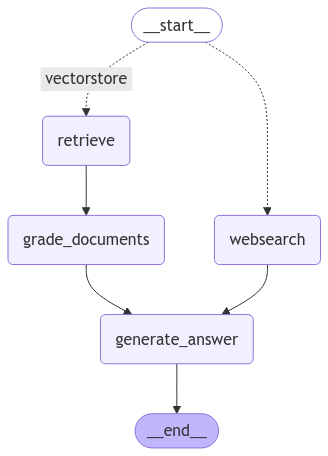

In [16]:
from typing import List, Literal
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph
from langchain.schema import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_ollama import ChatOllama
from langchain_chroma import Chroma
from prompts import ROUTER_INSTRUCTIONS, DOCUMENT_GRADER_INSTRUCTIONS, RESPONSE_INSTRUCTIONS
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from langchain_community.tools.tavily_search import TavilySearchResults
import os
from dotenv import load_dotenv
from IPython.display import Image, display

load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = os.getenv(var)

_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "mljobs-rag"

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

db = Chroma(
    persist_directory='./chroma',
    embedding_function=OpenAIEmbeddings(model="text-embedding-3-small")
)
retriever = db.as_retriever(search_kwargs={"k": 4})
web_search_tool = TavilySearchResults(max_results=4)

llm = ChatOllama(model="deepseek-r1:7b")
llm_openai = ChatOpenAI(model="gpt-4o-mini")

class GraphState(TypedDict):
    documents: List
    question: str
    answer: str
    loop_step: int
    
class RouterAnswer(BaseModel):
    datasource: Literal["websearch", "vectorstore"] = Field(
        None, description="Whether the data source should be a web search or vectorstore"
    )

class DocumentGraderAnswer(BaseModel):
    binary_score: Literal['yes', 'no'] = Field(
        ..., description="Indicates whether the document contains relevant information to the question."
    )
    
def route(state: GraphState): 
    question = state["question"]
    
    router_llm = llm_openai.with_structured_output(RouterAnswer)
    router_prompt = ROUTER_INSTRUCTIONS.format(question=question)
    result = router_llm.invoke(router_prompt)
    source = result.datasource
    
    if source == "websearch":
        print("---ROUTING QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTING QUESTION TO VECTOR STORE---")
        return "vectorstore"
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")

    # Web search
    docs = web_search_tool.invoke({"query": state["question"]})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": docs}
        
def retrieve(state: GraphState):
    print("---RETRIEVE---")
    
    documents = retriever.invoke(state["question"])
    return {"documents": documents}

def grade_documents(state: GraphState):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    document_grader = llm_openai.with_structured_output(DocumentGraderAnswer)
    
    filtered_docs = []
    for doc in documents:
        doc_grader_instructions = DOCUMENT_GRADER_INSTRUCTIONS.format(
            document = doc.page_content,
            question = question
        )
        result = document_grader.invoke(doc_grader_instructions)    
        
        if result.binary_score == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(doc)
    
    return {"documents": filtered_docs}

def generate_answer(state: GraphState):
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)
    
    response_prompt = RESPONSE_INSTRUCTIONS.format(context=documents, question=question)
    answer = llm.invoke(response_prompt)
    return {"answer": answer, "loop_step": loop_step + 1}

workflow = StateGraph(GraphState)

workflow.add_node("websearch", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate_answer", generate_answer)

workflow.set_conditional_entry_point(
    route,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("websearch", "generate_answer")
workflow.add_edge("grade_documents", "generate_answer")
workflow.add_edge("generate_answer", END)

# Add memory
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
inputs = {
    "question": "Does knowing how to build RAGs helpful for getting a job in Machine Learning?",
}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTING QUESTION TO VECTOR STORE---
{'question': 'Does knowing how to build RAGs helpful for getting a job in Machine Learning?'}
---RETRIEVE---
{'documents': [Document(metadata={'company_name': 'Nuage Technology Group', 'id': 'e307514bd26172cac4724480d66944d66124742af9414d208c59a985eb03abd7:2', 'location': 'Melbourne VIC', 'role': 'LLM Engineer', 'source': 'https://www.seek.com.au/job/81171888'}, page_content='**Responsibilities**\n\n*   Work closely with stakeholders to understand user requirements and translate them into scalable AI solutions.\n*   Continuously monitor and refine LLM systems to ensure optimal performance and alignment with evolving business needs.\n*   Experiment with and implement state-of-the-art methodologies to improve AI model performance and reliability.\n*   Collaborate with the broader team to prioritize and deliver impactful features on time.\n\n**Skillset & Experience**\n\n*   Proven experience deploying and optimizing large language models in productio